In [5]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
# Make tensorflow not take over the entire GPU memory
# for gpu in tf.config.experimental.list_physical_devices('GPU'):
#     tf.config.experimental.set_memory_growth(gpu, True)
from torch_ga import GeometricAlgebra
from torch_ga.layers import GeometricProductDense, TensorToGeometric, GeometricToTensor

In [6]:
# !pip install matplotlib
# !pip3 install torch torchvision torchaudio
# !conda install -y pytorch torchvision -c pytorch
# !conda update -n base -c defaults conda
# !conda install pytorch_lightning -c conda-forge
# !pip install pytorch-lightning
# !conda remove -y pytorch torchvision  
# !conda install -y pytorch torchvision torchaudio -c pytorch-nightly  #for python 3.11
# !micromamba install -y pytorch torchvision -c pytorch
# !micromamba install -y matplotlib

/var/folders/r0/xpvbfwgj0z702wqrkvq7y9rm0000gq/T/ipykernel_28602/266064819.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


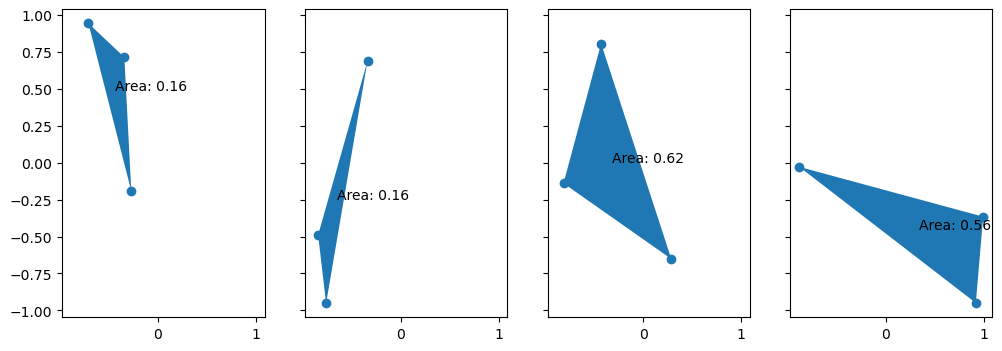

In [7]:
def make_batch(batch_size):
    # triangle_points = torch.rand([batch_size, 3, 2], minval=-1, maxval=1)
    triangle_points = torch.rand([batch_size, 3, 2])
    # triangle_points = torch.FloatTensor(shape=[batch_size, 3, 2])
    # print(f"triangle_points.shpae={triangle_points.shape}")
    triangle_points = triangle_points.uniform_(-1, 1)
    x, y = triangle_points[..., 0], triangle_points[..., 1]
    # print([batch_size, 3, 2])
    # print(f"triangle_points.shpae={triangle_points.shape}")
    # print(f"x.shpae={x.shape}")
    # print(f"y.shpae={y.shape}")
    ax, ay, bx, by, cx, cy = x[..., 0], y[..., 0], x[..., 1], y[..., 1], x[..., 2], y[..., 2]
    triangle_areas = 0.5 * torch.abs(ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))
    return triangle_points, triangle_areas

num_samples = 4
sample_points, sample_areas = make_batch(num_samples)

fig, axes = plt.subplots(1, num_samples, figsize=(12, 4), sharex=True, sharey=True)
for i, ax in enumerate(axes):
    points = sample_points[i]
    area = sample_areas[i]
    # center = tf.reduce_mean(points, axis=0)
    center = points.mean(dim=0)
    ax.scatter(points[..., 0], points[..., 1])
    ax.add_patch(plt.Polygon(points))
    ax.annotate("Area: %.2f" % area, center)
fig.show()

In [8]:
ga = GeometricAlgebra([1, 1])
s_indices = [0]
v_indices = [1, 2]
mv_indices = torch.arange(ga.num_blades)

class Squeeze(nn.Module):
    def __init_(self):
        super().__init__()
    def forward(self,x):
        return torch.squeeze(x)
    
model = nn.Sequential(
    TensorToGeometric(ga, blade_indices=v_indices),
    GeometricProductDense(
        ga, units=128, activation="relu",
        blade_indices_kernel=mv_indices,
        blade_indices_bias=mv_indices,
    ),
    # GeometricProductDense(
    #     ga, units=16, activation="relu",
    #     blade_indices_kernel=mv_indices,
    #     blade_indices_bias=mv_indices,
    # ),
    # GeometricProductDense(
    #     ga, units=16, activation="relu",
    #     blade_indices_kernel=mv_indices,
    #     blade_indices_bias=mv_indices,
    # ),
    GeometricProductDense(
        ga, units=1,
        blade_indices_kernel=mv_indices,
        blade_indices_bias=s_indices,
    ),
    GeometricToTensor(ga, blade_indices=s_indices),
    # nn.Flatten(),
    Squeeze(),
)

# [B, 3, 2]

print("Samples:", sample_points)
print("Model(Samples):", model(sample_points))

Samples: tensor([[[-0.2724, -0.1921],
         [-0.7103,  0.9422],
         [-0.3435,  0.7124]],

        [[-0.3372,  0.6886],
         [-0.8417, -0.4895],
         [-0.7603, -0.9515]],

        [[ 0.2870, -0.6519],
         [-0.4297,  0.8053],
         [-0.8132, -0.1399]],

        [[-0.8823, -0.0291],
         [ 0.9934, -0.3659],
         [ 0.9186, -0.9494]]])
Model(Samples): tensor([-0.5073, -0.5074, -0.5073, -0.5074], grad_fn=<SqueezeBackward0>)


In [9]:
# !pip install pytorch_lightning
# !pip install --upgrade pytorch_lightning
# !pip install --no-cache-dir pytorch_lightning
# !pip install rich
# !pip uninstall -y rich
# !pip uninstall -y pytorch_lightning
# !pip install --no-cache-dir pygments
# !pip uninstall -y pygments
# !pip install pygments==2.14
# !pip install pygments
# !pip install --upgrade rich

# !pip list | grep pygments

# !conda install -y -c conda-forge pytorch-lightning 

    # lightning-utilities-0.7.1  |   py38hecd8cb5_0          31 KB
    # pytorch-lightning-1.9.3    |     pyhd8ed1ab_0         433 KB  conda-forge
    # torchmetrics-0.11.2        |   py38h01d92e1_0         425 KB
    
    
# !conda install -y -c conda-forge rich

# !mamba install -y -c conda-forge pytorch-lightning 

 

In [10]:
train_points, train_areas = make_batch(1024)
test_points, test_areas = make_batch(128)

import pytorch_lightning as pl
# import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

class Lighting(pl.LightningModule):
    def __init__(self,module):
        super().__init__()
        self.module = module
        self.loss = nn.MSELoss()        
    def forward(self, x):
        return self.module(x)
    # def configure_optimizers(self):
    #     # return torch.optim.Adam(self.module.parameters(), lr=0.02)
    #     return torch.optim.Adam(self.module.parameters(), lr=1e-1)
    def configure_optimizers(self):
        # optimizer = torch.optim.Adam(self.module.parameters(), lr=2e-2)
        optimizer = torch.optim.SGD(self.module.parameters(), lr=2e-2)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        # ['train_loss', 'train_loss_step', 'val_loss', 'train_loss_epoch'] "metric_to_track"
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "train_loss"}
    
    def training_step(self,batch,batch_idx):
        x,y = batch
        y_hat = self.module(x)
        loss = self.loss(y,y_hat)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.module(x)
        loss = self.loss(y_hat, y)
        self.log("val_loss", loss)        



# def compile(model, optimizer,loss,metrics,learning_rate=1e-3):
#     if optimizer in ['Adam']: 
#         optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     if loss in ['mse']: 
#         loss = nn.MSELoss()
#     return optimizer,loss

# def fit(model, x, y, validation_data, epochs, optimizer):
#     for ep in epochs:
#         for xi,yi in zip(x,y):
#             y_ = model(xi)
#             loss_ = loss(yi,y_)
            
        

# optimizer, loss = compile(model, optimizer="Adam", loss="mse", metrics=["mae"])
# model.fit(x=train_points, y=train_areas, validation_data=(test_points, test_areas), epochs=100)

net = Lighting(model)

# tr_dataloader = DataLoader(TensorDataset(train_points, train_areas), batch_size=128, shuffle=True, drop_last=True)
# va_dataloader = DataLoader(TensorDataset(test_points, test_areas), batch_size=128, shuffle=True, drop_last=True)

# tr_dataloader = DataLoader(TensorDataset(train_points, train_areas), batch_size=32, shuffle=True, drop_last=True)
# va_dataloader = DataLoader(TensorDataset(test_points, test_areas), batch_size=32, shuffle=False, drop_last=True)

tr_dataloader = DataLoader(TensorDataset(train_points, train_areas), batch_size=16, shuffle=True)
va_dataloader = DataLoader(TensorDataset(test_points, test_areas), batch_size=16, shuffle=False)



# from pytorch_lightning.callbacks import RichProgressBar

# trainer = Trainer(callbacks=[RichProgressBar()])
# trainer = pl.Trainer(max_epochs=100,progress_bar_refresh_rate=20,callbacks=[RichProgressBar()]) 
# trainer = pl.Trainer(max_epochs=10,progress_bar_refresh_rate=2,callbacks=[RichProgressBar()]) 
# gpus=1,

# trainer = pl.Trainer(max_epochs=10,progress_bar_refresh_rate=2) 

trainer = pl.Trainer(max_epochs=100)

trainer.fit(net, train_dataloaders=tr_dataloader, val_dataloaders = va_dataloader)



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/alesiani/micromamba/envs/py310/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(

  | Name   | Type       | Params
--------------------------------------
0 | module | Sequential | 2.6 K 
1 | loss   | MSELoss    | 0     
--------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010   

Sanity Checking: 0it [00:00, ?it/s]

/Users/alesiani/micromamba/envs/py310/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/alesiani/micromamba/envs/py310/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/Users/alesiani/micromamba/envs/py310/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
print(model)

Sequential(
  (0): TensorToGeometric()
  (1): GeometricProductDense(
    (activation_fn): ReLU()
  )
  (2): GeometricProductDense()
  (3): GeometricToTensor()
  (4): Squeeze()
)


In [ ]:
ns = 10
test_points[:ns],test_areas[:ns], model(test_points[:ns])

(tensor([[[ 0.9599,  0.5308],
          [ 0.9931, -0.0074],
          [ 0.4458, -0.1191]],
 
         [[ 0.0385, -0.8597],
          [ 0.9593, -0.9105],
          [ 0.2042, -0.2816]],
 
         [[-0.9778, -0.4034],
          [ 0.1877, -0.4885],
          [ 0.7837, -0.9810]],
 
         [[-0.8942,  0.0678],
          [ 0.5932, -0.5717],
          [-0.1048, -0.4310]],
 
         [[-0.7299, -0.6463],
          [ 0.4873,  0.5691],
          [-0.4174,  0.5976]],
 
         [[ 0.2382, -0.2111],
          [ 0.4096, -0.5207],
          [ 0.2046,  0.5275]],
 
         [[ 0.7507,  0.5753],
          [ 0.5859, -0.3652],
          [ 0.0047,  0.6874]],
 
         [[ 0.2595, -0.9640],
          [-0.4363,  0.5308],
          [ 0.9110, -0.3024]],
 
         [[-0.6465, -0.8111],
          [ 0.3858, -0.5020],
          [ 0.5590,  0.6300]],
 
         [[ 0.7354, -0.7575],
          [-0.8138, -0.2470],
          [-0.5632, -0.8980]]]),
 tensor([0.1491, 0.2704, 0.2616, 0.1186, 0.5671, 0.0581, 0.3600, 0.717

In [ ]:
# # print(model.summary())

# https://www.pytorchlightning.ai/blog/using-optuna-to-optimize-pytorch-lightning-hyperparameters

# def objective(trial):
#     # PyTorch Lightning will try to restore model parameters from previous trials if checkpoint
#     # filenames match. Therefore, the filenames for each trial must be made unique.
#     checkpoint_callback = pl.callbacks.ModelCheckpoint(
#         os.path.join(MODEL_DIR, "trial_{}".format(trial.number)), monitor="accuracy"
#     )

#     # The default logger in PyTorch Lightning writes to event files to be consumed by
#     # TensorBoard. We create a simple logger instead that holds the log in memory so that the
#     # final accuracy can be obtained after optimization. When using the default logger, the
#     # final accuracy could be stored in an attribute of the `Trainer` instead.
#     logger = DictLogger(trial.number)

#     trainer = pl.Trainer(
#         logger=logger,
#         val_percent_check=PERCENT_TEST_EXAMPLES,
#         checkpoint_callback=checkpoint_callback,
#         max_epochs=EPOCHS,
#         gpus=0 if torch.cuda.is_available() else None,
#         early_stop_callback=PyTorchLightningPruningCallback(trial, monitor="accuracy"),
#     )

#     model = LightningNet(trial)
#     trainer.fit(model)

#     return logger.metrics[-1]["accuracy"]

/var/folders/r0/xpvbfwgj0z702wqrkvq7y9rm0000gq/T/ipykernel_24422/1309345364.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


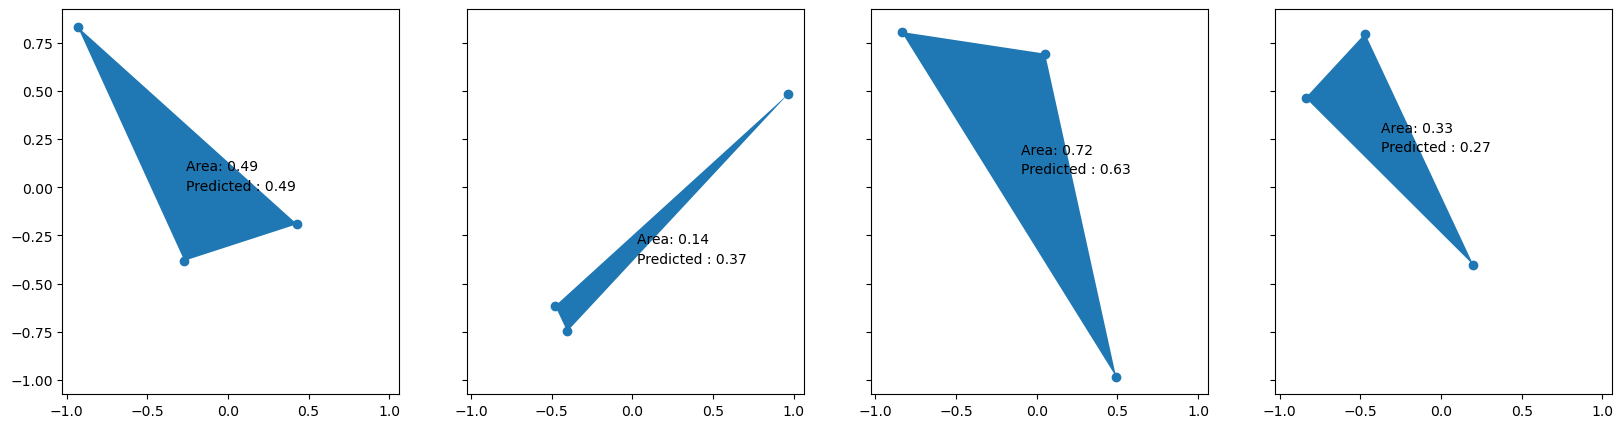

In [ ]:
predicted_sample_areas = model(sample_points)

fig, axes = plt.subplots(1, num_samples, figsize=(20, 5), sharex=True, sharey=True)
for i, ax in enumerate(axes):
    points = sample_points[i]
    area = sample_areas[i]
    predicted_area = predicted_sample_areas[i]
    center = points.mean(dim=0)
    ax.scatter(points[..., 0], points[..., 1])
    ax.add_patch(plt.Polygon(points))
    ax.annotate("Area: %.2f" % area, center)
    ax.annotate("Predicted : %.2f" % predicted_area, center + torch.tensor([0, -0.1]))
fig.show()

/var/folders/r0/xpvbfwgj0z702wqrkvq7y9rm0000gq/T/ipykernel_24422/2310040077.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


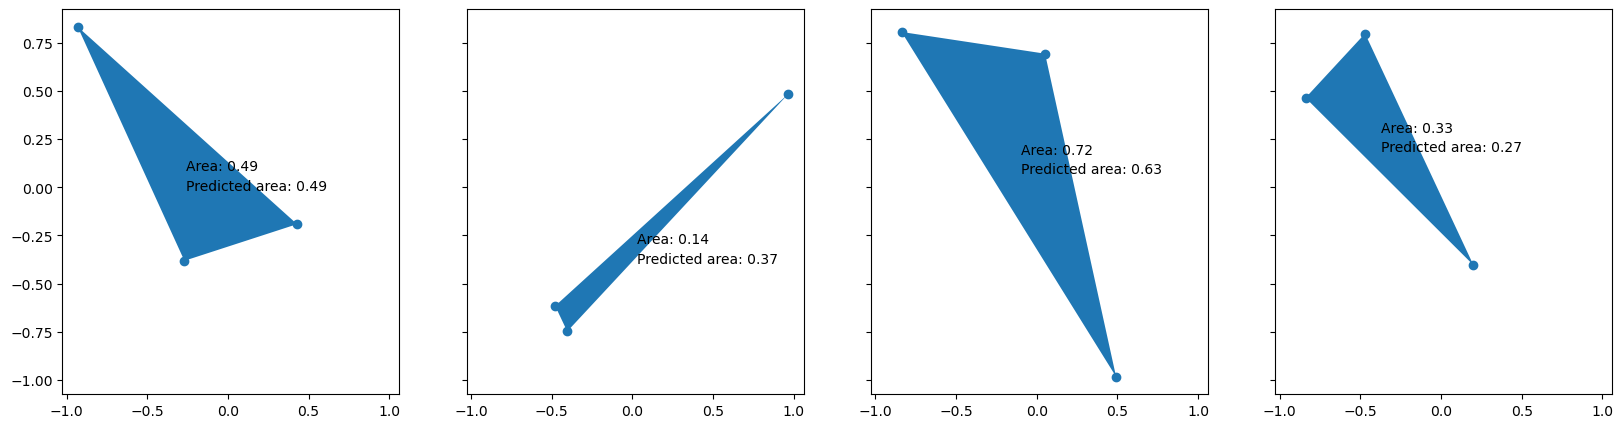

In [34]:
predicted_sample_areas = model(sample_points)

fig, axes = plt.subplots(1, num_samples, figsize=(20, 5), sharex=True, sharey=True)
for i, ax in enumerate(axes):
    points = sample_points[i]
    area = sample_areas[i]
    predicted_area = predicted_sample_areas[i]
    center = torch.mean(points, dim=0)
    ax.scatter(points[..., 0], points[..., 1])
    ax.add_patch(plt.Polygon(points))
    ax.annotate("Area: %.2f" % area, center)
    ax.annotate("Predicted area: %.2f" % predicted_area, center + torch.tensor([0, -0.1]))
fig.show()

In [35]:
model_normal = nn.Sequential(
    nn.Linear(6,64*2),
    nn.ReLU(),
    nn.Linear(64*2,64*2),
    nn.ReLU(),
    nn.Linear(64*2,1)
)


net = Lighting(model_normal)

tr_dataloader = DataLoader(TensorDataset(train_points.view(-1,6), train_areas), batch_size=128, shuffle=True, drop_last=True)
va_dataloader = DataLoader(TensorDataset(test_points.view(-1,6), test_areas), batch_size=128, shuffle=True, drop_last=True)

trainer = pl.Trainer(max_epochs=100)

trainer.fit(net, train_dataloaders=tr_dataloader, val_dataloaders = va_dataloader)


# model_normal.compile(optimizer="Adam", loss="mse", metrics=["mae"])
# model_normal.fit(x=tf.reshape(train_points, [-1, 6]), y=train_areas, validation_data=(tf.reshape(test_points, [-1, 6]), test_areas), epochs=100)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | module | Sequential | 17.5 K
1 | loss   | MSELoss    | 0     
--------------------------------------
17.5 K    Trainable params
0         Non-trainable params
17.5 K    Total params
0.070     Total estimated model params size (MB)


/Users/alesiani/micromamba/envs/py310/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/alesiani/micromamba/envs/py310/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/alesiani/micromamba/envs/py310/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. 

Epoch 0:  89%|████████▉ | 8/9 [00:00<00:00, 118.46it/s, loss=0.133, v_num=27, train_loss_step=0.140] 

/Users/alesiani/micromamba/envs/py310/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 99: 100%|██████████| 9/9 [00:00<00:00, 88.88it/s, loss=0.0775, v_num=27, train_loss_step=0.0787, train_loss_epoch=0.0774] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 9/9 [00:00<00:00, 77.42it/s, loss=0.0775, v_num=27, train_loss_step=0.0787, train_loss_epoch=0.0774]


In [36]:
print(model_normal)

Sequential(
  (0): Linear(in_features=6, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=1, bias=True)
)


/var/folders/r0/xpvbfwgj0z702wqrkvq7y9rm0000gq/T/ipykernel_24422/3222735657.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


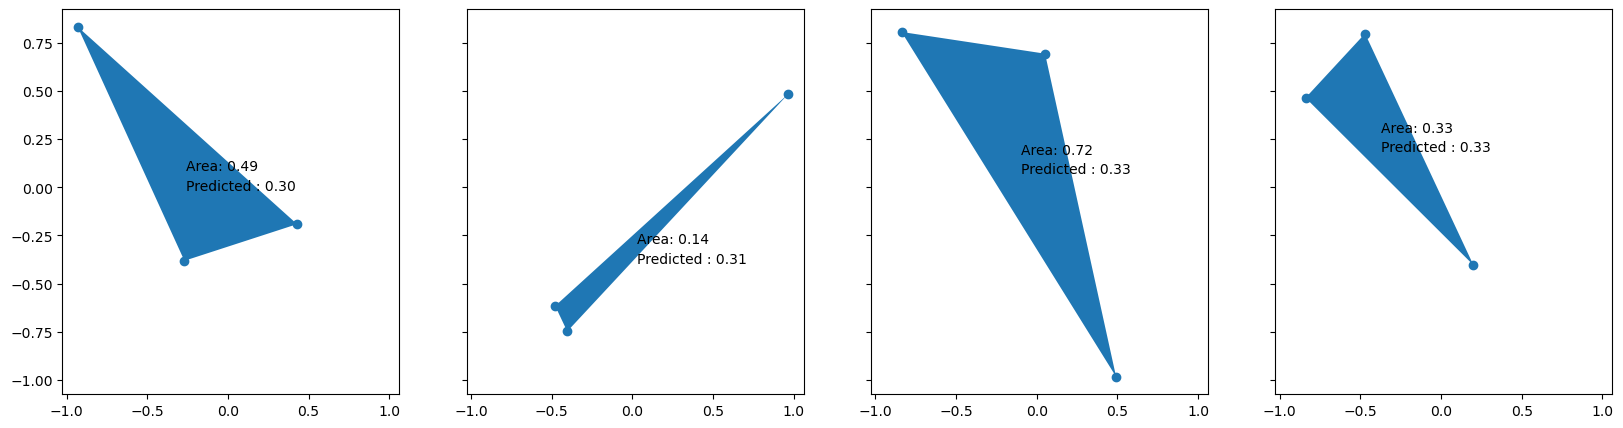

In [37]:
predicted_sample_areas = model_normal(sample_points.view(-1,6))

fig, axes = plt.subplots(1, num_samples, figsize=(20, 5), sharex=True, sharey=True)
for i, ax in enumerate(axes):
    points = sample_points[i]
    area = sample_areas[i]
    predicted_area = predicted_sample_areas[i]
    center = points.mean(dim=0)
    ax.scatter(points[..., 0], points[..., 1])
    ax.add_patch(plt.Polygon(points))
    ax.annotate("Area: %.2f" % area, center)
    ax.annotate("Predicted : %.2f" % predicted_area, center + torch.tensor([0, -0.1]))
fig.show()

In [38]:
# model_normal = tf.keras.Sequential([
#     tf.keras.layers.Dense(64*2, activation="relu"),
#     tf.keras.layers.Dense(64*2, activation="relu"),
#     tf.keras.layers.Dense(1)
# ])

# model_normal.compile(optimizer="Adam", loss="mse", metrics=["mae"])
# model_normal.fit(x=tf.reshape(train_points, [-1, 6]), y=train_areas, validation_data=(tf.reshape(test_points, [-1, 6]), test_areas), epochs=100)

In [8]:
print(model_normal.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (32, 128)                 896       
_________________________________________________________________
dense_1 (Dense)              (32, 128)                 16512     
_________________________________________________________________
dense_2 (Dense)              (32, 1)                   129       
Total params: 17,537
Trainable params: 17,537
Non-trainable params: 0
_________________________________________________________________
None


/var/folders/r0/xpvbfwgj0z702wqrkvq7y9rm0000gq/T/ipykernel_24422/1002773920.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


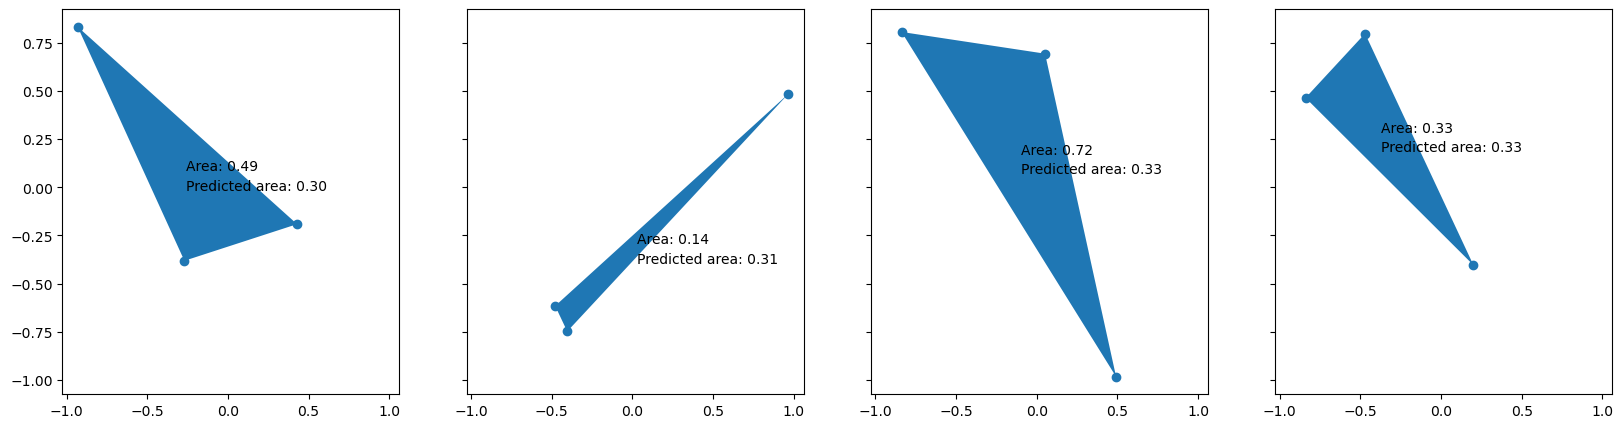

In [40]:
predicted_sample_areas = model_normal(torch.reshape(sample_points, [-1, 6]))

fig, axes = plt.subplots(1, num_samples, figsize=(20, 5), sharex=True, sharey=True)
for i, ax in enumerate(axes):
    points = sample_points[i]
    area = sample_areas[i]
    predicted_area = predicted_sample_areas[i]
    center = torch.mean(points, axis=0)
    ax.scatter(points[..., 0], points[..., 1])
    ax.add_patch(plt.Polygon(points))
    ax.annotate("Area: %.2f" % area, center)
    ax.annotate("Predicted area: %.2f" % predicted_area, center + torch.tensor([0, -0.1]))
fig.show()